# Mu Capital Research- Investigating Stocks and Portfolios

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
import matplotlib.pyplot as plt

In [115]:
end = dt.datetime.today().strftime('%Y-%m-%d')
start = (dt.datetime.today()-dt.timedelta(days=365)).strftime('%Y-%m-%d')
AZ = web.DataReader('AZN', data_source='yahoo', start=start, end=end)
rets = AZ['Close'].pct_change().dropna()
display(AZ.tail()) 
display(rets)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-07-20,64.940002,57.650002,62.689999,58.680000,56346600.0,58.680000
2020-07-21,59.650002,57.840000,59.650002,58.070000,15419100.0,58.070000
2020-07-22,57.889999,56.240002,57.380001,56.980000,9562100.0,56.980000
2020-07-23,56.840000,54.810001,56.750000,55.169998,8444100.0,55.169998
2020-07-24,56.000000,55.060001,55.310001,55.799999,7690975.0,55.799999


Date
2019-07-29    0.020225
2019-07-30   -0.011940
2019-07-31   -0.010260
2019-08-01    0.013591
2019-08-02    0.006364
                ...   
2020-07-20   -0.039607
2020-07-21   -0.010395
2020-07-22   -0.018770
2020-07-23   -0.031766
2020-07-24    0.011419
Name: Close, Length: 251, dtype: float64

Read in the previous year of Astrazeneca OHLC price data and calculate the daily returns as 'rets'

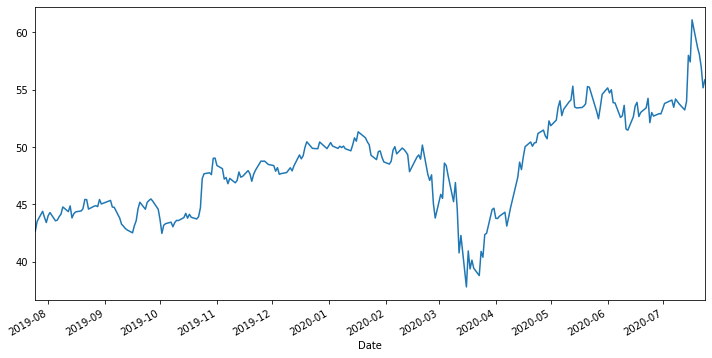

In [5]:
AZ['Close'].plot(figsize=(12,6))

Plot the close data. Note the dip between March and April

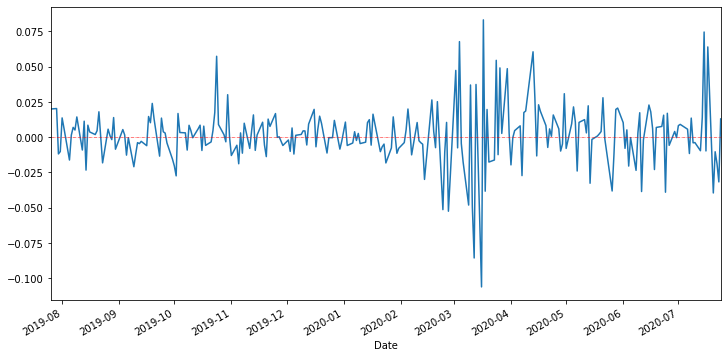

In [6]:
ax = rets.plot.line(figsize=(12,6))
ax.axhline(y=0,xmin=0,xmax=3,c="red",linewidth=0.5, linestyle='dashdot')

Plot the daily returns over the past year

# Risk Statistics

In [7]:
def drawdown(return_series: pd.Series):
    wealth_index = 1000*(1+return_series).cumprod()
    prev_peaks = wealth_index.cummax()
    max_drawdown = (wealth_index-prev_peaks)/prev_peaks
    return pd.DataFrame({'Wealth Index':wealth_index, 'Previous Peak':prev_peaks, 'Drawdown':max_drawdown})

Max drawdown (MDD) is the maximum observed loss from a peak to a trough of a portfolio, before a new peak is attained. Maximum drawdown is an indicator of downside risk over a specified time period. Think of Max drawdown as how bad it would be if you bought at the largest price seen, and sold at the lowest price seen.

In [8]:
def annualize_vol(r, periods_per_year):
    return r.std()*(periods_per_year**0.5)
annualize_vol(rets, periods_per_year=rets.shape[0])

0.3373646658470394

In [10]:
def annualize_rets(r, periods_per_year):
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return (compounded_growth**(periods_per_year/n_periods)-1)

annualize_rets(rets, 252)

0.30989220037480036

Make functions to take returns over a specified period, e.g. daily, monthly, quarterly etc. and annualize the returns and volatility

In [9]:
def semideviation(r):
    is_negative = r < 0
    return is_negative.std(ddof=0)
semideviation(rets)

0.49842280851135184

Semideviation is a measure of 'downside volatility', so when the returns are negative, how volatile are they when they are negative is the question semideviation answers

In [11]:
def sharpe_ratio(r, risk_free_rate, periods_per_year):
    # convert the annual riskfree rate to per period
    rf_per_period = (1+risk_free_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

sharpe_ratio(rets, 0.02, periods_per_year=rets.shape[0])

0.8424934168009567

Sharpe ratio is a measure of risk adjusted returns. A high sharpe ratio is desirable. The formula is $$ S = \frac{\mu-r_{f}}{\sigma}\ $$

In [12]:
def var_historic(r, level=5):
    if isinstance(r, pd.DataFrame):
        r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

VaR (Value at Risk) at level x% answers the question: what is the threshold value such that the worst x% of returns fall below this value. For example if the level is 5% and the VaR is -0.03 then of all of the observed returns only 5% are below -0.03

In [13]:
print('var historic is: {}' .format(var_historic(rets, level=5)))
print('Worst 5% of daily returns at or below -0.028999062081370534')

var historic is: -0.030795652010407543
Worst 5% of daily returns at or below -0.028999062081370534


In [14]:
def cvar_historic(r, level=5):
    if isinstance(r, pd.Series):
        is_beyond = r <= var_historic(r, level=level)
        return r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")
print('cvar_historic is: {}' .format(cvar_historic(rets, level=5)))
print('In the worst 5% of daily returns the average return is -0.0500072098131498')

cvar_historic is: -0.05014286073784945
In the worst 5% of daily returns the average return is -0.0500072098131498


CVaR answers the question: when it's bad, how bad? It does this by taking the average loss once the VaR is breached.

In [15]:
def skewness(r):
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3


def kurtosis(r):
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4

Skewness and kurtosis measure symmetry and 'tailedness' resp. So if the return distribution is negative skewed then returns are more positive on the whole, and if there is a high kurtosis then there are more instances of extreme returns rather than most returns being centred around the mean.

In [16]:
from scipy.stats import norm
def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
        
    return (r.mean() + z*r.std(ddof=0))

var_gaussian(rets, level=5, modified=True)
print('Cornish-Fisher VaR is: {}' .format(var_gaussian(rets, level=5, modified=True)))
print('Worst 5% of daily returns at or below -0.03226843853731585')

Cornish-Fisher VaR is: -0.03263799338220327
Worst 5% of daily returns at or below -0.03226843853731585


This is a theoretical rather than empirical way of calculating the VaR. It assumes normality for distributed returns (not true!) then modifies the quantile value to increase the kurtosis and make the value more accurate

In [110]:
def summary_stats(r, risk_free_rate=0.02, name=_):
    periods=r.shape[0]
    ann_rets = r.aggregate(annualize_rets, periods_per_year=periods)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=periods)
    ann_sr = r.aggregate(sharpe_ratio, risk_free_rate=risk_free_rate, periods_per_year=periods)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    semidev = r.aggregate(semideviation)
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    return pd.DataFrame({
        "Annualized Return": ann_rets,
        "Annualized Vol": ann_vol,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Historic CVaR (5%)": hist_cvar5,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd,
        "Semi-Deviation": semidev,
        'Skewness': skew,
        'Kurtosis': kurt
        }, index=name)
summary_stats(rets, name=['AstraZeneca'])

,Annualized Return,Annualized Vol,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown,Semi-Deviation,Skewness,Kurtosis
AstraZeneca,0.309892,0.337365,-0.032638,-0.050143,0.842493,-0.263783,0.498423,-0.195479,7.940951


A function that takes all the previous statistics and compiles them into a neat table.

The max-drawdown was -0.264 which occured at 2020-03-16


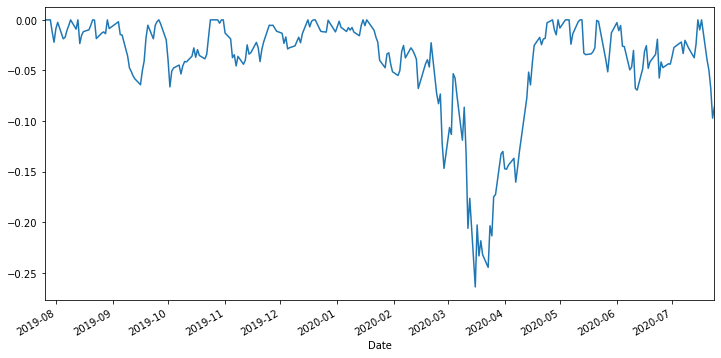

In [18]:
drawdown(rets).Drawdown.plot(figsize=(12,6))
print('The max-drawdown was {} which occured at {}'.format(np.round(drawdown(rets).Drawdown.min(),3), str(drawdown(rets).Drawdown.idxmin().date())))

As probably expected the max drawdown occured during the market turmoil of Mar-Apr 2020.

# Monte Carlo Simulation

In [19]:
import os
os.chdir('/Users/maxjackson/Downloads')

In [20]:
end = dt.datetime.today().strftime('%Y-%m-%d')
start = (dt.datetime.today()-dt.timedelta(days=2*365)).strftime('%Y-%m-%d')
ext_rets = web.DataReader('NYA', data_source='yahoo', start=start, end=end)['Close'].pct_change().dropna()

Gather returns since 2018

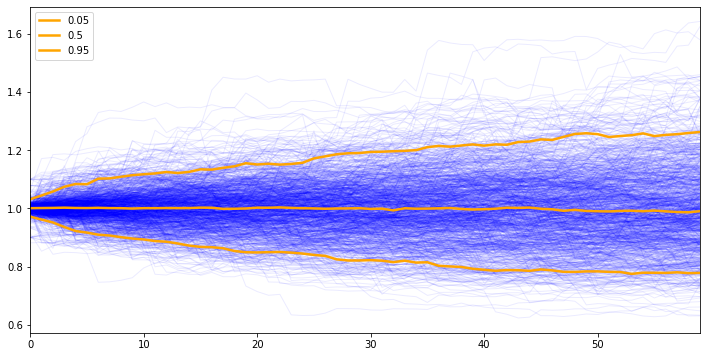

In [21]:
import random
def bootstrap(rets, future_period=60, scenarios=1000, lo=0.05, med=0.5, hi=0.95):
    fig, ax = plt.subplots(1, figsize=(12,6))
    sim = pd.DataFrame((rets.iloc[random.choices(range(len(rets)), k=future_period)]).cumprod().values for i in range(scenarios)).T
    sim.plot(ax=ax, legend=False,linewidth=1,alpha=0.08,color='blue')
    sim.quantile([lo, med, hi],axis=1).T.plot(ax=ax, legend='False', color='orange',linewidth=2.5)
bootstrap(1+ext_rets)

What the code does is sample 60 days worth of returns from the last 2 years of AZN returns, and calculate the cumulative returns over the 60 day period. This is repeated 1000 times. The orange lines represent the bounds such that the 5% most extreme simulations lie below the bottom line, and the other 5% above the top line, while 50% lie above/below the middle line.

Monte Carlo simulation shows little to no reliable obvious upward trend (look at quantiles) of the stock. Not the be-all-end-all but evidence to suggest possibly not the best investment.

# CAPM Factor Analysis

In [22]:
import os
os.chdir('/Users/maxjackson/Downloads/data')

In [23]:
end = dt.datetime.today().strftime('%Y-%m-%d')
start = (dt.datetime.today()-dt.timedelta(days=5*365)).strftime('%Y-%m-%d')
ext_rets = web.DataReader('NYA', data_source='yahoo', start=start, end=end)['Close'].pct_change().dropna()

Pull in OHLC data & find returns

In [55]:
FFMI = pd.read_csv("F-F_Research_Data_Factors_daily.CSV", header=0, index_col=0, na_values=-99.99, parse_dates=True)[:-2]/100
FFMI.index=pd.to_datetime(FFMI.index, format='%Y%m%d')
FFMI=FFMI.loc[ext_rets.index[0]:, :]
ext_rets=ext_rets.loc[:FFMI.index[-1]]
display(FFMI.head()), display(ext_rets.head())

,Mkt-RF,SMB,HML,RF
2015-08-06,-0.0088,-0.0053,0.0199,0.0
2015-08-07,-0.0036,-0.0046,-0.0035,0.0
2015-08-10,0.0132,0.0016,0.0069,0.0
2015-08-11,-0.0098,-0.0008,0.0043,0.0
2015-08-12,0.0007,-0.0009,-0.0028,0.0


Date
2015-08-06   -0.004462
2015-08-10    0.009871
2015-08-25   -0.111279
2015-08-26    0.029640
2015-08-27    0.025134
Name: Close, dtype: float64

(None, None)

Pull in Kenneth French's 3 Factor daily dataset for the market factor data

Next, we need to decompose the observed AZ into the portion that's due to the market and the rest that is not due to the market using the CAPM as the explanatory model.
i.e.

$$ R_{AZ,t} - R_{f,t} = \alpha + \beta(R_{mkt,t} - R_{f,t}) + \epsilon_t $$

Will disregard the alpha as we're not looking at a fund's return vs the market so dont expect any 'alpha' due to active investing of a fund manager

In [25]:
import statsmodels.api as sm
exp_var = pd.DataFrame(FFMI['Mkt-RF'].copy())
AZ_excess = ext_rets-FFMI['RF']
exp_var = exp_var[AZ_excess.notna()]
AZ_excess = AZ_excess[AZ_excess.notna()]
exp_var['Constant']=1
lm = sm.OLS(AZ_excess, exp_var).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     2512.
Date:                Fri, 24 Jul 2020   Prob (F-statistic):          2.77e-249
Time:                        16:36:18   Log-Likelihood:                 3211.6
No. Observations:                 804   AIC:                            -6419.
Df Residuals:                     802   BIC:                            -6410.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.9069      0.018     50.116      0.000       0.871       0.942
Constant      -0.0002      0.000     -1.484      0.138      -0.001    7.53e-05
==============================================================================
Omnibus:                     1570.069   Durbin-Watson:                   1.821
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3488379.241
Skew:                         -13.898   Prob(JB):                         0.00
Kurtosis:                     324.494   Cond. No.                         115.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Beta of 0.9 so theory suggests AZ returns quite closely follow movements of the market returns. Must remember: theoretical so tread lightly!

Let's bring in some other stocks to try and diversify away some unrewarded specific risk. Lets bring in some non-pharma stocks to avoid potential industry specific risk.

Lets do large cap Tesla (TSLA), a small cap real estate company Redfin (RDFN) and low volatility Clorox (CLX). 

Will plot the efficient frontier, do a 3 factor Fama French analysis of different portfolios, followed by a CPPI strategy.

# Diversifying

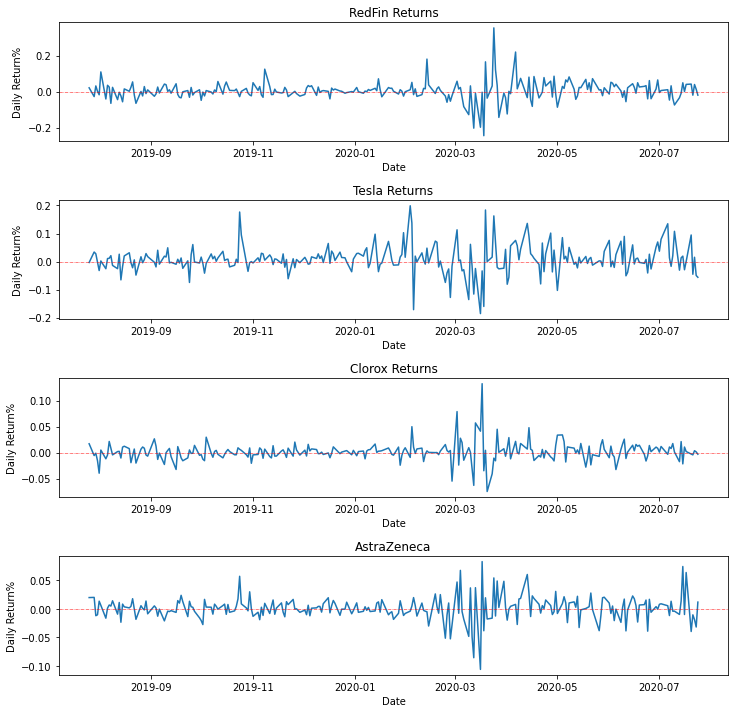

In [26]:
start = (dt.datetime.today()-dt.timedelta(days=365)).strftime('%Y-%m-%d')
RF = web.DataReader('RDFN', data_source='yahoo', start=start, end=end)['Close'].pct_change().dropna()
TS = web.DataReader('TSLA', data_source='yahoo', start=start, end=end)['Close'].pct_change().dropna()
CX = web.DataReader('CLX', data_source='yahoo', start=start, end=end)['Close'].pct_change().dropna()
AZ = web.DataReader('AZN', data_source='yahoo', start=start, end=end)['Close'].pct_change().dropna()

stocks = [RF, TS, CX, AZ]
titles = ['RedFin Returns', 'Tesla Returns', 'Clorox Returns', 'AstraZeneca']
tickers = ['RF', 'TS', 'CX', 'AZ']

fig, ax = plt.subplots(len(stocks), figsize=(12,12))
fig.subplots_adjust(hspace=.5)
for i, txt in enumerate(stocks):
    ax[i].plot(txt)
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel('Daily Return%')
    ax[i].set_title(titles[i])
    ax[i].axhline(y=0,xmin=0,xmax=3,c="red",linewidth=0.5, linestyle='dashdot')

Read in and plot the stock data over the past year. All go crazy around the same time of Mar-Apr 2020. Tesla spends a lot of time well above the 0 line and very modestly below.

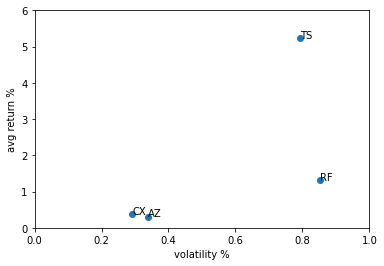

In [27]:
vols = [annualize_vol(stock, periods_per_year=stock.shape[0]) for stock in stocks]
avg_returns = [annualize_rets(stock, periods_per_year=stock.shape[0]) for stock in stocks]
fig, ax = plt.subplots()
ax.scatter(vols, avg_returns)

for i, txt in enumerate(tickers):
    ax.annotate(txt, (vols[i], avg_returns[i]), size=10)
    ax.set_xlabel('volatility %')
    ax.set_ylabel('avg return %')
    ax.set_xlim(0,1)
    ax.set_ylim(0,6)


Plot volatility vs annualized return to get a sense of the stocks vs one another. Tesla high risk very high reward, Redfin high risk good reward, Clorox low vol (as expected) and meager reward, very similar properties to Astrazeneca.

# Plotting the Efficient Frontier

In [28]:
returns = pd.DataFrame({'RF': RF, 'TS': TS, 'CX': CX, 'AZ': AZ})
cov = returns.cov()
er = annualize_rets(returns, len(returns))

Need annualized returns and the covariance matrix of the returns

In [29]:
print(er)
cov

RF    1.322911
TS    5.240581
CX    0.388688
AZ    0.308720
dtype: float64


,RF,TS,CX,AZ
RF,0.002882,0.001336,0.000085,0.000410
TS,0.001336,0.002493,0.000069,0.000396
CX,0.000085,0.000069,0.000338,0.000133
AZ,0.000410,0.000396,0.000133,0.000452


In [30]:
def portfolio_return(weights, returns):
    return weights.T @ returns

def portfolio_vol(weights, covmat):
    return (weights.T @ covmat @ weights)**0.5

Functions to find portfolio returns and volatilities given weights and stock returns

In [31]:
from scipy.optimize import minimize
def minimize_vol(target_return, er, cov):
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),)*n
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights)-1
                       }
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return-portfolio_return(weights, er)
                       }
    weights = minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp':False},
                       constraints=(weights_sum_to_1, return_is_target),
                       bounds=bounds)
    return weights.x

Find the weights of the portfolio which has the minimum volatitity for a given target return

In [32]:
def optimal_weights(n_points, er, cov):
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(r, er, cov) for r in target_rs]
    return weights

Make a list of portfolio weights given equally spaced target returns. Basically finds points on the efficient frontier

In [33]:
def plot_ef(n_points, er, cov, a=12, b=6, lower_x=0):
    weights = optimal_weights(n_points, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({'Returns':rets,
                       'Volatility':vols
                      })
    return ef.plot.line(x='Volatility', y='Returns', style='.-', xlim=(lower_x, max(vols)), figsize=(a,b))

Plots the efficient frontier of a portfolio

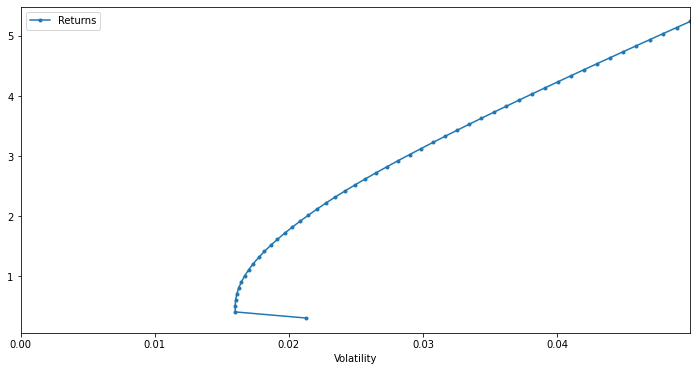

In [34]:
plot_ef(50, er, cov)

# Add Some Portfolios to the Efficient Frontier
In order:
- Maximum Sharpe Ratio Portfolio
- Global Minimum Variance Portfolio
- Cap Weighted Portfolio
- Equally Weighted Portfolio
- Risk Parity Portfolio

In [35]:
def msr(riskfree_rate, er, cov):
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),)*n
    
    weights_sum_to_1 = {'type':'eq',
                        'fun': lambda weights: np.sum(weights)-1
                       }
    def neg_sharpe_ratio(weights, riskfree_rate, er, cov):
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r-riskfree_rate)/vol
    
    weights = minimize(neg_sharpe_ratio, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp':False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

Find the weights of the portfolio which maximizes the Sharpe Ratio given a set of expected returns and covariance matrix

In [36]:
def gmv(cov):
    n = cov.shape[0]
    return msr(0, np.repeat(1,n), cov)

A useful portfolio since it avoids the treachery of estimating expected returns is the Global Minimum Variance (GMV) portfolio. We want to get the weights of the GMV portfolio (which is the leftmost point on the curve).  This can be done if we think carefully about the Max Sharpe Ratio (MSR) portfolio. If all returns are constant, then the only way to maximize sharpe ratio is to minimize the portfolio variance (the denominator of the Sharpe ratio formula) so we get the GMV portfolio.

In [37]:
def cw(caps):
    """
    Returns weights of capweighted portfolio given dictionary of market caps
    """
    return caps/caps.sum()#np.divide(list(caps.values()),sum(caps.values()))

Given caps for each stock in a portfolio, find each stock's capweight.

In [38]:
def ew(er):
    n=er.shape[0]
    return np.repeat(1/n, n)

Finds weights of a portfolio of $n$ assets. Returns $\frac{1}{n}$  for each weight

In [39]:
def risk_contribution(w, cov):
    """
    Compute the contributions to risk of the constituents of a portfolio, 
    given a set of portfolio weights and a covariance matrix
    """
    total_portfolio_vol = portfolio_vol(w, cov)**2
    marginal_contrib = cov@w
    risk_contrib = np.multiply(marginal_contrib, w.T)/total_portfolio_vol
    return risk_contrib

Some stocks will be contributing more risk to the portfoio than others. What if we made a portfolio where the weight of each stock is such that each stock contributes equally to the total risk of the portfolio? This is what the risk-parity portfolio does.

In [40]:
def target_risk_contributions(target_risk, cov):
    """
    Returns the weights of the portfolio that gives you the weights such
    that the contributions to portfolio risk are as close as possible to
    the target_risk, given the covariance matrix
    """
    n = cov.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),)*n
    
    weights_sum_to_1 = {'type':'eq',
                        'fun': lambda weights: np.sum(weights)-1}
    
    def msd_risk(weights, target_risk, cov):
        """
        Returns the Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        w_contribs = risk_contribution(weights, cov)
        return ((w_contribs-weights)**2).sum()
    
    weights = minimize(msd_risk, init_guess,
                      args=(target_risk, cov), method='SLSQP',
                      options={'disp':False},
                      constraints=(weights_sum_to_1,), 
                      bounds=bounds)
    return weights.x

Given a set of target risks for each asset (summing to 1), this function tells you what weight is needed of each asset to achieve the target risk.

In [41]:
def equal_risk_contributions(cov):
    """
    Returns the weights of the portfolio that equalizes the contributions
    of the constituents based on the given covariance matrix
    """
    n = cov.shape[0]
    return target_risk_contributions(np.repeat(1/n,n), cov)

Returns target risk when each asset has equal risk contribution to the portfolio, i.e. a risk contribution of $\frac{1}{n}$ for each n assets

In [42]:
caps = pd.Series({'RF':4.05e9, 'TS':293.95e9, 'CX':28.66e9, 'AZ':115.49e9})
caps

RF    4.050000e+09
TS    2.939500e+11
CX    2.866000e+10
AZ    1.154900e+11
dtype: float64

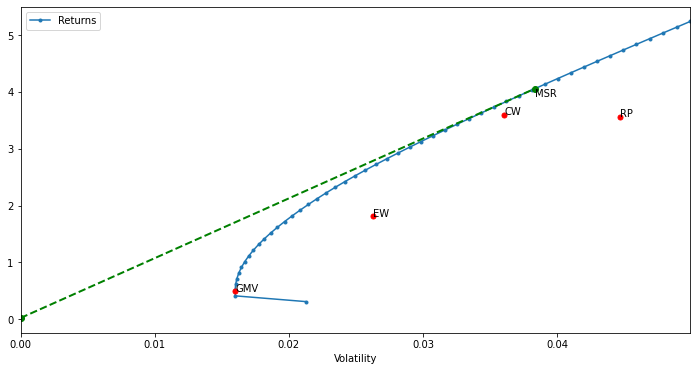

In [43]:
ax = plot_ef(50, er, cov)
rf = 0.02
w_msr = msr(rf,er,cov)
r_msr = portfolio_return(w_msr, er)
vol_msr = portfolio_vol(w_msr, cov)
#Add Capital Market Line
cml_x = [0, vol_msr]
cml_y = [rf, r_msr]

ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=6)
ax.annotate('MSR', (cml_x[1], cml_y[1]), verticalalignment='top')

w_gmv = gmv(cov)
w_cw = cw(caps)
w_ew = ew(er)
w_erc = equal_risk_contributions(cov)

weights = [(w_gmv, 'GMV'), (w_cw, 'CW'), (w_ew, 'EW'), (w_erc, 'RP')]

for w, weighting in weights:
    ax.plot(portfolio_vol(w, cov), portfolio_return(w, er), 'or', markersize=5)
    ax.annotate(weighting, (portfolio_vol(w, cov), portfolio_return(w, er)), size=10)

Plot the efficient frontier, as well as each portfolio's position inside the efficient frontier. Adds the capital market line joining the risk free rate of 0.02 to the Max Sharpe Ratio portfolio. Good to see the GMV and MSR portfolios are as expected. The cap weighted portfolio looks to be doing very well, close to the MSR portfolio. Due to Tesla having the largest cap and Tesla's outstanding performance the last year contributing a lot to the portfolio's performance. The equally weighted portfolio performs respectably- this portfolio is quite often held in practice I believe.

# Backtesting and Comparing the Portfolios' Performances

In [44]:
def sample_cov(r, **kwargs):
    """
    Returns the sample covariance of the supplied returns
    """
    return r.cov()

def weight_gmv(r, cov_estimator=sample_cov, **kwargs):
    """
    Produces the weights of the GMV portfolio given a covariance matrix of the returns 
    """
    est_cov = cov_estimator(r, **kwargs)
    return gmv(est_cov)
#btr = backtest_ws(returns, weighting=weight_gmv, cov_estimator=sample_cov)

def weight_erc(r, cov_estimator=sample_cov, **kwargs):
    """
    Produces the weights of the ERC portfolio given a covariance matrix of the returns 
    """
    est_cov = cov_estimator(r, **kwargs)
    return equal_risk_contributions(est_cov)


def weight_ew(r):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame
    """
    n = len(r.columns)
    return pd.Series(1/n, index=r.columns)

def weight_cw(r, cap_weights, **kwargs):
    """
    Returns the weights of the CW portfolio based on the time series of capweights
    """
    w = cap_weights.loc[r.index[0]]
    return w/w.sum()

def backtest_ws(r, estimation_window=5, weighting=ew, **kwargs):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", and a variable number of keyword-value arguments
    """
    n_periods = r.shape[0]
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    # windows is a list of tuples which gives us the (integer) location of the start and stop (non inclusive)
    # for each estimation window
    weights = [weighting(r.iloc[win[0]:win[1]], **kwargs) for win in windows]
    # List -> DataFrame
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window-1:].index, columns=r.columns)
    # return weights
    returns = (weights * r).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns

Create a function which in rolling windows of 5 days, uses these 5 days of data to calculate weights of the portfolio given a weighting e.g. CW, EW, GMV then calculates the returns of the portfolio given the weighting method.

In [45]:
def backtest_msr(r, estimation_window=5, **kwargs):
    n_periods = r.shape[0]
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    rets = [r.iloc[win[0]:win[1]] for win in windows]
    data = [(annualize_rets(item, len(item)), item.cov()) for item in rets]
    weights = [msr(riskfree_rate=0.02, er=er, cov=cov) for er, cov in data]
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window-1:].index, columns=r.columns)
    returns = (weights * r).sum(axis='columns', min_count=1)
    return returns
                       

Modifying the backtest function to find the max sharpe ratio portfolio  

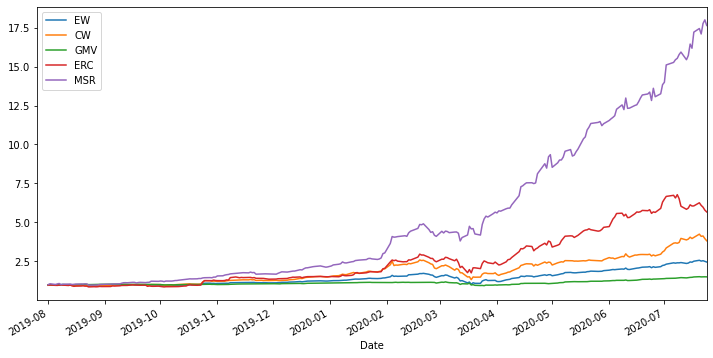

In [113]:
returns = pd.concat({'RF':RF, 'TS':TS, 'CX':CX, 'AZ':AZ}, axis='columns')
cap_weights = pd.DataFrame(index=returns.index, columns=caps.index)
cap_weights[tickers]=caps.values

cwr = backtest_ws(returns, weighting=weight_cw, cap_weights=cap_weights)
ewr = backtest_ws(returns, weighting=weight_ew)
gmv_r = backtest_ws(returns, weighting=weight_gmv, cov_estimator=sample_cov)
erc_r = backtest_ws(returns, weighting=weight_erc, cov_estimator=sample_cov)
msr_r = backtest_msr(returns)
btr = pd.DataFrame({"EW": ewr,'CW':cwr, "GMV": gmv_r, "ERC": erc_r, 'MSR':msr_r})

(1+btr).cumprod().plot(figsize=(12,6))
#display(summary_stats(r=[cwr, ewr], name=['cw','ew']))

In [112]:
summary_stats(btr.dropna(), name=['EW', 'CW', 'GMV', 'ERC', 'MSR'])

,Annualized Return,Annualized Vol,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown,Semi-Deviation,Skewness,Kurtosis
EW,1.459118,0.416337,-0.038216,-0.062985,3.389206,-0.403470,0.477222,-0.389815,10.597570
CW,2.822686,0.571933,-0.050965,-0.082829,4.804895,-0.487178,0.493454,-0.032722,6.978607
GMV,0.507677,0.213197,-0.022283,-0.032503,2.242799,-0.204105,0.484123,-2.230364,23.148363
ERC,4.673543,0.673676,-0.048842,-0.082644,6.773228,-0.405180,0.494096,0.687087,8.509259
MSR,16.637571,0.542067,-0.030199,-0.062616,30.061733,-0.224160,0.439775,0.957594,8.985900


- MSR hugely outperforms as expected since it finds the portfolio with most optimal risk adjusted returns at each step. Virtually impossible to hold this portofolio in real life however.
- All dip in Mar-Apr 2020, GMV least as expected.
- GMV returns least. Minimizng vol --> doesn't benefit from as much upside vol.
- CW better than EW.
- Equal Risk Contribution portfolio best by considerable amount- ERC known to be a desirable portfolio.

# Fama French 3- Factor Model

This will give us information on the size (SMB) and value/growth (HML) tilts of the portfolio as well as how the portfolio compares to the market. Lets take the equally weighted portfolio for simplicity.

$$ R_{brka,t} - R_{f,t} = \alpha + \beta(R_{mkt,t} - R_{f,t}) +\beta(R_{SMB,t}) +\beta(R_{HML, t}) + \epsilon_t $$
Will again ignore $\alpha$

In [119]:
FFMI = pd.read_csv("F-F_Research_Data_5_Factors_2x3_daily.CSV", header=0, index_col=0, na_values=-99.99, parse_dates=True).loc[ewr.index[0]:ewr.index[-1],:]/100
FFMI.index=pd.to_datetime(FFMI.index, format='%Y%m%d')
FFMI.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
2019-07-26,0.0082,0.0032,-0.0021,-0.0064,-0.0032,0.00009
2019-07-29,-0.0032,-0.0032,-0.0046,0.0035,0.0041,0.00009
2019-07-30,-0.0017,0.0138,0.0085,-0.0024,0.0008,0.00009
2019-07-31,-0.0109,0.0025,0.0053,0.0014,0.0047,0.00009
2019-08-01,-0.0104,-0.0080,-0.0194,-0.0042,-0.0021,0.00007


Pull in the daily factor data from Kenneth French's library

In [91]:
portf_excess = ewr-FFMI['RF']
portf_excess = portf_excess[portf_excess.notna()]

exp_var = pd.DataFrame(FFMI['Mkt-RF'].copy())
exp_var['Value'] = FFMI['HML']
exp_var['Size'] = FFMI['SMB']
exp_var = exp_var.loc[portf_excess.index[0]:,:]

lm = sm.OLS(portf_excess, exp_var).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.655
Model:                            OLS   Adj. R-squared (uncentered):              0.650
Method:                 Least Squares   F-statistic:                              144.3
Date:                Fri, 24 Jul 2020   Prob (F-statistic):                    2.02e-52
Time:                        20:31:22   Log-Likelihood:                          628.24
No. Observations:                 231   AIC:                                     -1250.
Df Residuals:                     228   BIC:                                     -1240.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         1.0075      0.053     19.072      0.000       0.903       1.112
Value         -0.5404      0.102     -5.300      0.000      -0.741      -0.339
Size           0.7854      0.136      5.777      0.000       0.517       1.053
==============================================================================
Omnibus:                       22.368   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.764
Skew:                           0.373   Prob(JB):                     1.05e-13
Kurtosis:                       5.378   Cond. No.                         3.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The loading on the market is 1.0075 which means the portfolio's volatility is not much different to the market's.

We can interpret the loadings on Value being negative as saying that the portfolio has a significant growth, not value, tilt - which should not be a shock considering the huge growth of Tesla and the very respectable growth of Redfin real estate. Additionally, the positive tilt on size suggests that the portfolio is comprised of large companies, which, again should not be a shock as we have Tesla, Clorox and Astrazeneca, all very big names.

In other words, the portfolio appears to be a large growth portfolio and even larger in large caps. Of course, we knew this from looking at the stocks comprising the portfolio, but the point here is that numbers reveal it!

# CPPI

Remember the volatility of all the stocks during Mar-Apr 2020. One thing that would be nice to do would be to protect against potential losses arising from this period. How could we do this? We could invest a greater proportion in safe assets e.g. bonds, and less in risky assets e.g. equities, until the market is stable and seems to be in our favour again. This is what CPPI (Constant Proportion Portfolio Insurance) does.

In [142]:
def run_cppi(risky_r, safe_r=None, m=3, start=1000, floor=0.8, riskfree_rate=0.02, drawdown=None):
    """
    Run a backtest of the CPPI strategy, given a set of returns for the risky asset
    Returns a dictionary containing: Asset Value History, Risk Budget History, Risky Weight History
    """
    # set up the CPPI parameters
    dates = risky_r.index
    n_steps = len(dates)
    account_value = start
    floor_value = start*floor
    peak = account_value
    if isinstance(risky_r, pd.Series): 
        risky_r = pd.DataFrame(risky_r, columns=["R"])

    if safe_r is None:
        safe_r = pd.DataFrame().reindex_like(risky_r)
        safe_r.values[:] = riskfree_rate/12 # fast way to set all values to a number
    # set up some DataFrames for saving intermediate values
    account_history = pd.DataFrame().reindex_like(risky_r)
    risky_w_history = pd.DataFrame().reindex_like(risky_r)
    cushion_history = pd.DataFrame().reindex_like(risky_r)
    floorval_history = pd.DataFrame().reindex_like(risky_r)
    peak_history = pd.DataFrame().reindex_like(risky_r)

    for step in range(n_steps):
        if drawdown is not None:
            peak = np.maximum(peak, account_value)
            floor_value = peak*(1-drawdown)
        cushion = (account_value - floor_value)/account_value
        risky_w = m*cushion
        risky_w = np.minimum(risky_w, 1)
        risky_w = np.maximum(risky_w, 0)
        safe_w = 1-risky_w
        risky_alloc = account_value*risky_w
        safe_alloc = account_value*safe_w
        # recompute the new account value at the end of this step
        account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
        # save the histories for analysis and plotting
        cushion_history.iloc[step] = cushion
        risky_w_history.iloc[step] = risky_w
        account_history.iloc[step] = account_value
        floorval_history.iloc[step] = floor_value
        peak_history.iloc[step] = peak
    risky_wealth = start*(1+risky_r).cumprod()
    backtest_result = {
        "Wealth": account_history,
        "Risky Wealth": risky_wealth, 
        "Risk Budget": cushion_history,
        "Risky Allocation": risky_w_history,
        "m": m,
        "start": start,
        "floor": floor,
        "risky_r":risky_r,
        "safe_r": safe_r,
        "drawdown": drawdown,
        "peak": peak_history,
        "floor": floorval_history
    }
    return backtest_result

The CPPI algorithm is surprisingly simple to implement. This takes as input, the returns of a risky asset and a safe asset, along with the initial wealth to invest at the start, along with a floor that should not be violated.
Now, we need to backtest this strategy by starting at the beginning and at every point in time:

1. Compute the cushion (asset value minus floor)
2. Compute the allocation (based on the multiplier)
3. Compute the new asset value


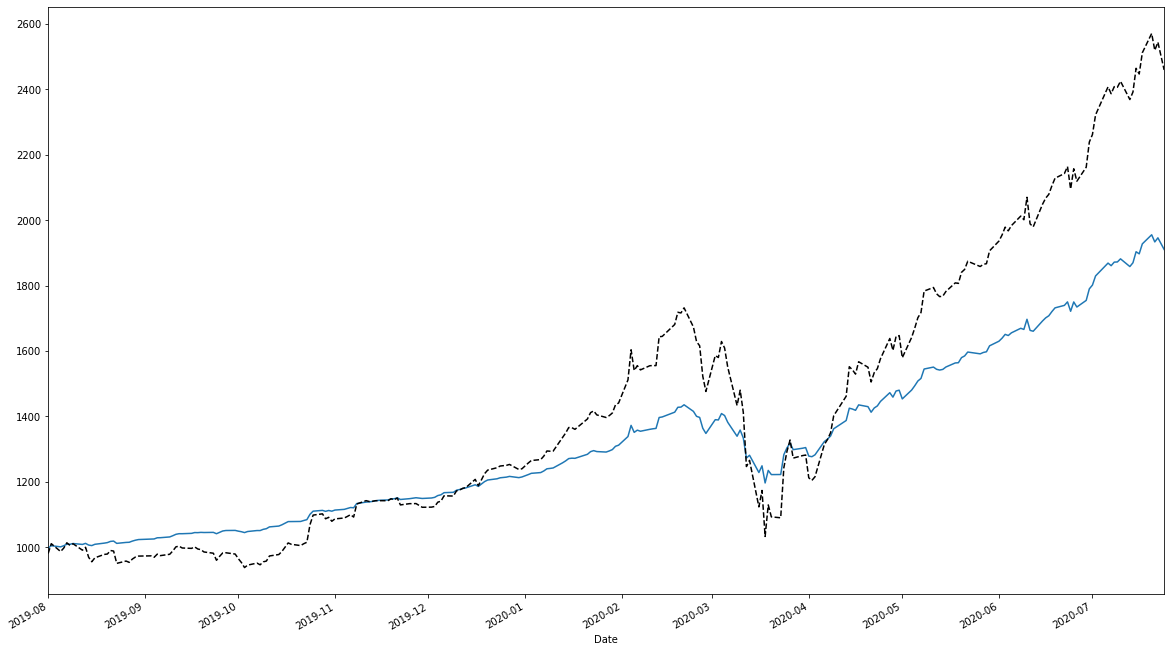

In [146]:
risky_r = pd.DataFrame(ewr.dropna())
safe_r = pd.DataFrame().reindex_like(risky_r)
safe_r[:] = 0.02/risky_r.shape[0]
btr = run_cppi(risky_r, m=1)

ax = btr['Wealth'].plot(figsize=(20,12), legend=False)
btr['Risky Wealth'].plot(ax=ax, style='k--', legend=False)

For simplicity I've taken the safe asset to return 2% per year (i.e. when assets are allocated to safe assets their value grows at 2% a year, and the risky asset is the equally weighted portfolio). The blue is when we run CPPI, and it does a good job of protecting from the downside risk in Mar-Apr 2020, though it does inauspiciously 'protect' from harvesting some upside risk hence the lower overall return.

# Summary
In summary, I wouldn't invest in Astrazeneca alone- we should definitely diversify. The max Sharpe Ratio portfolio would be absolutely ideal, but is not accessible due to the inability to meaningfully estimate expected returns. The GMV is a plausible position to hold however the returns are meager. A cap-weighted or equally-weighted portfolio is what I would go for here- the CW has higher risk but higher reward, the EW has a bit less risk and a bit less reward and neither requires any estimation risk.

# Thank you!